# Modelo de REGRESION LOGISTICA para predicción de comportamiento en marketing digital

El objetivo del siguiente proyecto es clasificar aquellos clientes del negocio que sean posibles candidatos a comprar un nuevo producto. Existen dos variables posible a predecir; una es la apertura de emails de publicidad por parte de los clientes y la otra es si hacen click en el enlace de dicho mail.

In [73]:

# Importamos librerias

import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, roc_auc_score, plot_roc_curve

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Limpieza de datos 

In [74]:
data= pd.read_csv(('DatasetModulo2.csv'))
pd.set_option('display.max_columns', 50)

### Columnas que no aportan y columnas duplicadas

In [75]:
# Eliminamos las columnas que tienen el mismo valor en todas sus filas 

columnas_fulla_eliminar = [x for x in data.columns if data[x].nunique()==1]

In [76]:
data.drop(columns=columnas_fulla_eliminar, inplace=True)

In [77]:
# Verificamos que la columna de PERIODO_CLI y PERIODO, tienen todos sus valores iguales

(data.periodo_cli==data.periodo).value_counts()

True    494887
dtype: int64

In [78]:
#Eliminamos la coumna PERIODO porque son iguales
data = data.drop(['periodo'],axis=1)

### Analisis las variables posibles a usar como target

[Text(0.5, 1.0, 'Frecuencia de la variable Traget: Hacer click en el link')]

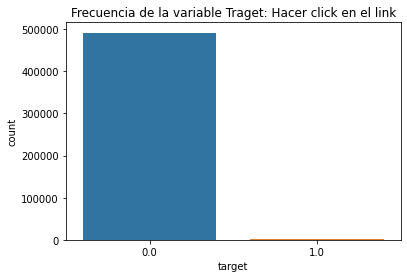

In [79]:
### Los que hicieron click en el link dentro del email

sns.countplot(x='target', data=data).set(title='Frecuencia de la variable Traget: Hacer click en el link')

In [80]:

data['target'].value_counts(normalize=True)

0.0000   0.9938
1.0000   0.0062
Name: target, dtype: float64

[Text(0.5, 1.0, 'Frecuencia de la variable Traget2: Entrar al email')]

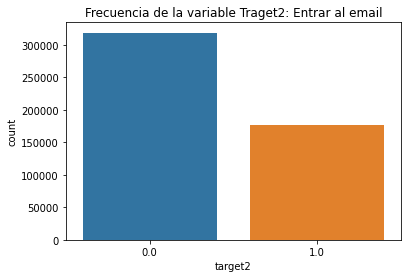

In [81]:
# Los que abrieron el email
sns.countplot(x='target2', data=data).set(title='Frecuencia de la variable Traget2: Entrar al email')

In [82]:
data['target2'].value_counts(normalize=True)

0.0000   0.6437
1.0000   0.3563
Name: target2, dtype: float64

In [83]:
# Se elimina la columna target ya que tiene muy pocas ocurrencias y por ende esta muy desbalanceada,
# no sirve para la construccion de un modelo predictivo.

# Seleccionamos Target2: Vamos a predecir que clientes son mas propensos a abrir los emails de publicidad 

data.drop(columns='target',inplace=True)

### Filas duplicadas


In [84]:
data.duplicated().any()

True

In [85]:
# Eliminamos las filas duplicadas
data.drop_duplicates(inplace=True)

In [86]:
data.shape

(485635, 38)

### Valores nulos

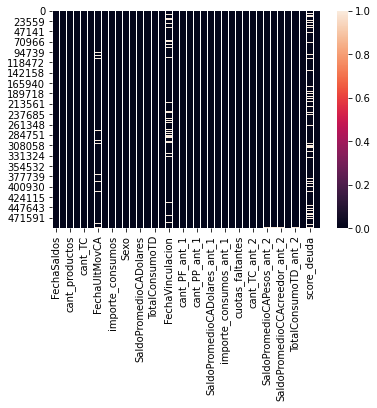

In [87]:
sns.heatmap(data[data.columns].isnull())

In [88]:
data.isnull().sum()

FechaSaldos                          0
periodo_cli                          0
cant_productos                       0
cant_PF                              0
cant_TC                              0
cant_PP                              0
FechaUltMovCA                    26071
cant_seguros                         0
importe_consumos                     0
Edad                                 0
Sexo                                 0
SaldoPromedioCAPesos                 0
SaldoPromedioCADolares               0
SaldoPromedioCCAcreedor              0
TotalConsumoTD                       0
CategoriaProducto                    0
FechaVinculacion                 77386
cuotas_faltantes_1                   0
cant_PF_ant_1                        0
cant_TC_ant_1                        0
cant_PP_ant_1                        0
SaldoPromedioCAPesos_ant_1         692
SaldoPromedioCADolares_ant_1       692
SaldoPromedioCCAcreedor_ant_1      692
importe_consumos_ant_1               0
TotalConsumoTD_ant_1     

In [89]:
# Columnas con valores nulos
for col in data.columns: 
    if data[col].isnull().sum() >0:
        print(col,data[col].isnull().sum()) 

FechaUltMovCA 26071
FechaVinculacion 77386
SaldoPromedioCAPesos_ant_1 692
SaldoPromedioCADolares_ant_1 692
SaldoPromedioCCAcreedor_ant_1 692
TotalConsumoTD_ant_1 692
SaldoPromedioCAPesos_ant_2 2780
SaldoPromedioCADolares_ant_2 2780
SaldoPromedioCCAcreedor_ant_2 2780
TotalConsumoTD_ant_2 2780
score_deuda 84754


#### Corregimos los valores nulos

In [90]:
# Columnas con valores nulos
cols = []
for col in data.columns: 
    if data[col].isnull().sum() >0:
        cols.append(col)
print(cols)

for column in data[cols]:
    data[column].fillna(data[column].mode()[0], inplace=True)

['FechaUltMovCA', 'FechaVinculacion', 'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1', 'SaldoPromedioCCAcreedor_ant_1', 'TotalConsumoTD_ant_1', 'SaldoPromedioCAPesos_ant_2', 'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2', 'TotalConsumoTD_ant_2', 'score_deuda']


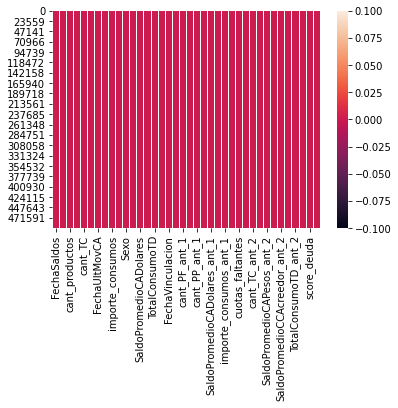

In [91]:
sns.heatmap(data[data.columns].isnull())

In [92]:
# corroboramos que no quede ninguna columna con valores nulos
for col in data.columns: 
    if data[col].isnull().sum() >0:
        print(col,data[col].isnull().sum()) 

### Transformaciones de datos


In [93]:
# Transformamos las variables objeto a tipo fecha
data['FechaUltMovCA']= pd.to_datetime(data['FechaUltMovCA'])

In [94]:
data['FechaVinculacion']= pd.to_datetime(data['FechaVinculacion'])

In [95]:
data['FechaSaldos']= pd.to_datetime(data['FechaSaldos'])

In [96]:
data.loc[data.FechaUltMovCA.isna(),'FechaUltMovCA']=pd.to_datetime('2019-09-20')

In [97]:
# Tratamos la variable sexo

In [98]:
data['Sexo'].value_counts()
data["Sexo"].unique().tolist()

['M', 'F', ' ']

In [99]:
data.Sexo = data.Sexo.str.replace(' ','Nan')

In [100]:
# remplazamos los valores nulos por F, que es la categoria con mas ocurrencia

data.loc[data['Sexo'] == 'Nan','Sexo'] = 'F'

In [101]:
#eliminanmos edades menores a 18 años, ya que posiblemente son datos erroneos 

data = data[data.Edad >= 18]

data.groupby('Edad').size()

Edad
18       64
19      256
20      900
21     1761
22     2630
       ... 
113       2
114       2
117       2
118      29
119      19
Length: 97, dtype: int64

In [102]:
## Categoria del producto
# Disminuimos la cantidad de categorias uniendo aquellas que tienen menos ocurrencia en una nueva variable :OTRAS

categ =data['CategoriaProducto'].value_counts(normalize=True)


In [103]:
otras =categ [5:]
otras =otras.index.tolist()


In [104]:
data.loc[data['CategoriaProducto'].isin(otras),'CategoriaProducto']='OTRAS'

In [105]:
data.CategoriaProducto.value_counts()

14       252307
10       102004
12        84631
OTRAS     20104
28        15229
19         9837
Name: CategoriaProducto, dtype: int64

### Outliers 

In [106]:
# Seleccionamos columnas numericas

data_cols_num = data.select_dtypes(include=np.number).columns 

In [107]:
data_cols_num

Index(['periodo_cli', 'cant_productos', 'cant_PF', 'cant_TC', 'cant_PP',
       'cant_seguros', 'importe_consumos', 'Edad', 'SaldoPromedioCAPesos',
       'SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor', 'TotalConsumoTD',
       'cuotas_faltantes_1', 'cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1',
       'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1', 'importe_consumos_ant_1',
       'TotalConsumoTD_ant_1', 'cuotas_faltantes', 'cant_PF_ant_2',
       'cant_TC_ant_2', 'cant_PP_ant_2', 'SaldoPromedioCAPesos_ant_2',
       'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2',
       'importe_consumos_ant_2', 'TotalConsumoTD_ant_2', 'cuotas_faltantes_2',
       'score_deuda', 'target2'],
      dtype='object')

#### Edad

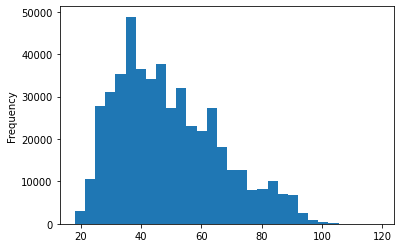

In [108]:
data['Edad'].plot.hist(bins=30)

In [109]:
saldo = data[['SaldoPromedioCAPesos', 'SaldoPromedioCADolares',
       'SaldoPromedioCCAcreedor','SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1','SaldoPromedioCAPesos_ant_2',
       'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2']]

In [110]:
pd.options.display.float_format = '{:.4f}'.format

In [111]:
saldo.describe()

,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCCAcreedor,SaldoPromedioCAPesos_ant_1,SaldoPromedioCADolares_ant_1,SaldoPromedioCCAcreedor_ant_1,SaldoPromedioCAPesos_ant_2,SaldoPromedioCADolares_ant_2,SaldoPromedioCCAcreedor_ant_2
count,484112.0000,484112.0000,484112.0000,484112.0000,484112.0000,484112.0000,484112.0000,484112.0000,484112.0000
mean,38466.1355,655.3538,934.6953,33376.7339,688.0691,851.3987,32136.0543,739.5453,804.7481
std,107114.0960,5537.9150,37893.9590,102404.1655,5623.8737,36769.7071,98881.6334,5935.3148,34814.7524
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,2928.6800,0.0000,0.0000,2424.4200,0.0000,0.0000,2303.2650,0.0000,0.0000
50%,14116.2100,0.0000,0.0000,11355.4950,0.0000,0.0000,10645.4200,0.0000,0.0000
75%,37516.5250,0.0300,0.0000,31189.3725,0.0000,0.0000,30120.4550,0.0000,0.0000
max,9412126.4800,757625.9600,11655409.7000,16024181.9100,757470.6800,13021518.2700,16024181.9100,753736.9200,14731642.9600


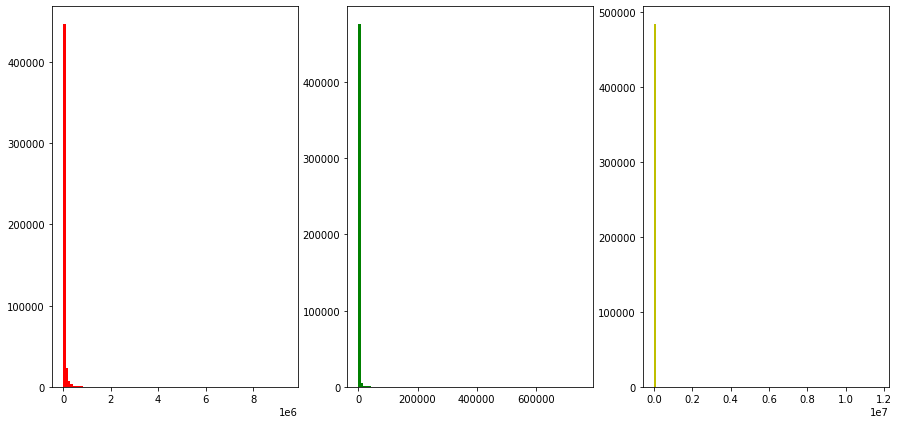

In [112]:
plt.figure(figsize=(15,7))
plt.subplot(1, 3, 1)
plt.hist(data['SaldoPromedioCAPesos'], bins = 90, color = 'r')
plt.subplot(1, 3, 2)
plt.hist(data['SaldoPromedioCADolares'], bins = 90, color = 'g')
plt.subplot(1, 3, 3)
plt.hist(data['SaldoPromedioCCAcreedor'], bins = 90, color = 'y')
plt.show()


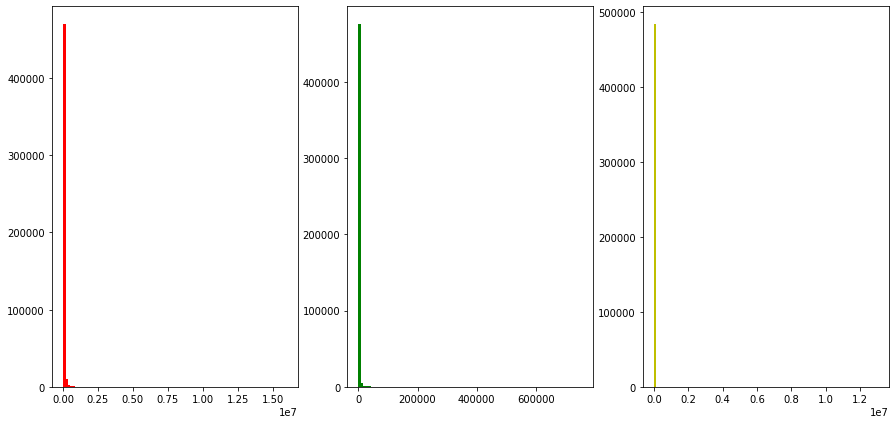

In [113]:
plt.figure(figsize=(15,7))
plt.subplot(1, 3, 1)
plt.hist(data['SaldoPromedioCAPesos_ant_1'], bins = 90, color = 'r')
plt.subplot(1, 3, 2)
plt.hist(data['SaldoPromedioCADolares_ant_1'], bins = 90, color = 'g')
plt.subplot(1, 3, 3)
plt.hist(data['SaldoPromedioCCAcreedor_ant_1'], bins = 90, color = 'y')
plt.show()



In [114]:
data['importe_consumos'].value_counts(normalize= True)

0       0.9993
84794   0.0000
1611    0.0000
11254   0.0000
844     0.0000
         ...  
42172   0.0000
11693   0.0000
18848   0.0000
4011    0.0000
3708    0.0000
Name: importe_consumos, Length: 317, dtype: float64

### Tratamiento de outliers por cada variable 

In [115]:
# Funcion para modificar los outlier fuera del cuantil 0.95

def cambiar(df ,col):
    df.loc[df[col]>df[col].quantile(0.975),col] = df[col].quantile(0.975)
    


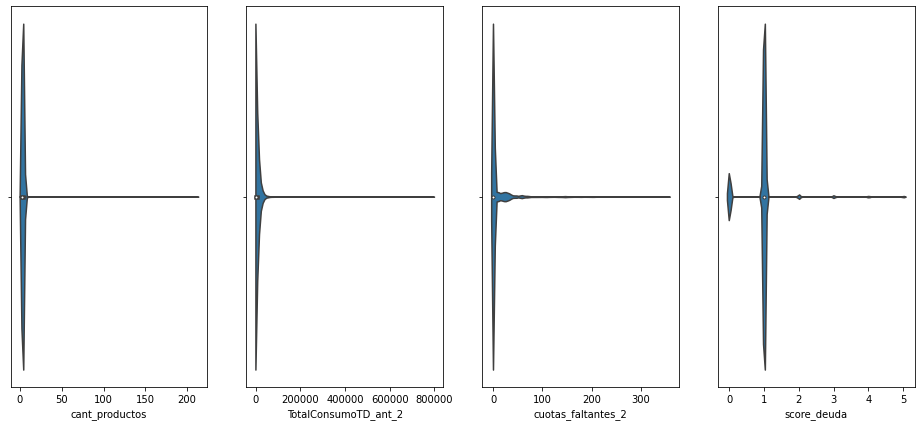

In [116]:
from seaborn import violinplot
plt.figure(figsize = (50,7))

plt.subplot(1,12,1)
violinplot(x= 'cant_productos', data=data)

plt.subplot(1,12,2)
violinplot(x='TotalConsumoTD_ant_2', data=data)

plt.subplot(1,12,3)
violinplot(x='cuotas_faltantes_2', data=data)


plt.subplot(1,12,4)
violinplot(x='score_deuda', data=data)

In [117]:
# aplicamos la funcion para eliminar outliers a todas las variables numericas 

#for col in data[data_cols_num]:
#    cambiar(data, col)

cambiar(data ,'cant_productos')
cambiar(data ,'periodo_cli')
cambiar(data ,'cant_PF')
cambiar(data ,'cant_TC',)

cambiar(data ,'cant_PP')
cambiar(data ,'cant_seguros')
cambiar(data ,'Edad',)

cambiar(data ,'SaldoPromedioCAPesos')
cambiar(data ,'SaldoPromedioCADolares')
cambiar(data ,'TotalConsumoTD')

cambiar(data ,'cuotas_faltantes_1')
cambiar(data ,'cant_PF_ant_1')
cambiar(data ,'cant_TC_ant_1')
cambiar(data ,'cant_PP_ant_1',)

cambiar(data ,'SaldoPromedioCAPesos_ant_1')
cambiar(data ,'SaldoPromedioCADolares_ant_1')
cambiar(data ,'SaldoPromedioCCAcreedor_ant_1')
cambiar(data ,'importe_consumos_ant_1',)

cambiar(data ,'TotalConsumoTD_ant_1')
cambiar(data ,'cuotas_faltantes')
cambiar(data ,'cant_PF_ant_2')
cambiar(data ,'cant_TC_ant_2',)

cambiar(data ,'cant_PP_ant_2')
cambiar(data ,'SaldoPromedioCAPesos_ant_2')
cambiar(data ,'SaldoPromedioCADolares_ant_2')


cambiar(data ,'TotalConsumoTD_ant_2')
cambiar(data ,'cuotas_faltantes_2')
cambiar(data , 'score_deuda',)


<Figure size 3600x504 with 0 Axes>

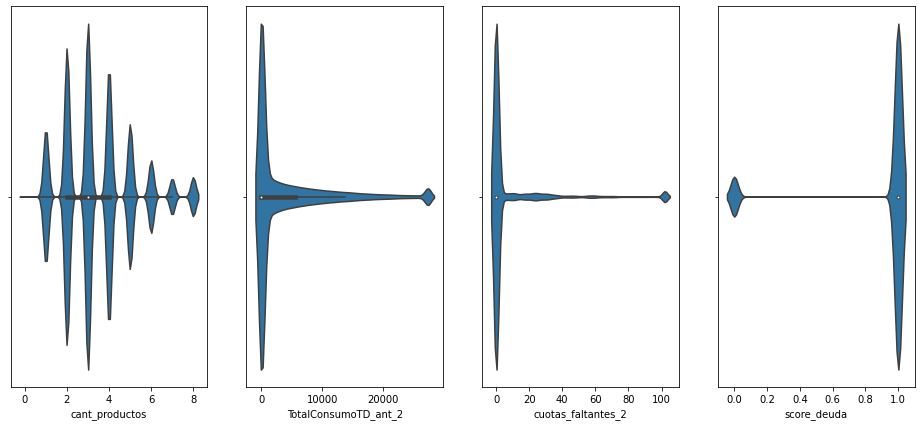

In [118]:
# Chequeamos que los cambios sean efectivos 

from seaborn import violinplot
plt.figure(figsize = (50,7))

from seaborn import violinplot
plt.figure(figsize = (50,7))

plt.subplot(1,12,1)
violinplot(x= 'cant_productos', data=data)

plt.subplot(1,12,2)
violinplot(x='TotalConsumoTD_ant_2', data=data)

plt.subplot(1,12,3)
violinplot(x='cuotas_faltantes_2', data=data)


plt.subplot(1,12,4)
violinplot(x='score_deuda', data=data)

columnas a las que no fue conveniente aplicar la modificacion de outliers :
"importe_consumos" - 'SaldoPromedioCCAcreedor' - 'SaldoPromedioCCAcreedor_ant_2' -  'importe_consumos_ant_2' - 

en duda : 'score_deuda'

 # Exploracion de variables 

### descripcion del input

#fecha de saldo
#cant_productos . debe ser la suma de los siguientes 3 aunque tambien hay otros productos por fuera de estos
#cant_pf = cantidd plazo fijo
#cant_tc=tarjeta de credito
#cant_pp = prestamo personal 
#fecha_ult_mov_cajadeahorro 
#cant_seguros
#importe consumos
#sexo
#CA= CAJA DE AHORRO
#totalconsumoTD =  total consumo tarjeta debito
#categoriaproducto = clasificacion de productos
#fechaviculacion = al dato
#coutas_faltantes_1= de algun prestamo
#cant_pf_ant = cantidad plazo fijo al mes actual
#score_deuda =  de 1 a 5 , en donde 1 es una deuda bien paga, y 5 es alguien con mucha deudas
#target = hizo clik en el link
#target 2= hizo click en el mail




In [119]:
# Analizamos la media y moda para la variable target en cada variable numerica para buscar patrones
# que diferencien al grupo de los que abre el mail y al grupo de los que no

data.groupby('target2').mean()


,periodo_cli,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes_1,cant_PF_ant_1,cant_TC_ant_1,cant_PP_ant_1,SaldoPromedioCAPesos_ant_1,SaldoPromedioCADolares_ant_1,SaldoPromedioCCAcreedor_ant_1,importe_consumos_ant_1,TotalConsumoTD_ant_1,cuotas_faltantes,cant_PF_ant_2,cant_TC_ant_2,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCADolares_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda
target2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0000,0.4689,3.2954,0.1021,1.2149,0.1821,0.4007,14.9385,48.0753,30170.6348,263.8785,791.6414,4921.0828,7.5623,0.0732,1.2131,0.1837,25989.5485,288.8160,0.2967,0.0000,4132.6185,7.4559,0.0676,1.2089,0.1843,25147.8794,307.9111,665.7983,11.2413,3985.6340,7.6558,0.8868
1.0000,0.6458,3.6011,0.1262,1.4422,0.1668,0.3931,32.0436,50.8516,35876.8740,340.8622,1192.8146,5297.1010,6.9361,0.0877,1.4296,0.1669,29918.8232,371.0315,0.3586,0.0000,4230.5345,6.8668,0.0816,1.4144,0.1667,28309.1841,406.9002,1055.4622,26.4261,4091.0773,6.9981,0.9139


In [120]:
data.groupby('target2').agg(lambda x:x.value_counts().index[0])

,FechaSaldos,periodo_cli,cant_productos,cant_PF,cant_TC,cant_PP,FechaUltMovCA,cant_seguros,importe_consumos,Edad,Sexo,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCCAcreedor,TotalConsumoTD,CategoriaProducto,FechaVinculacion,cuotas_faltantes_1,cant_PF_ant_1,cant_TC_ant_1,cant_PP_ant_1,SaldoPromedioCAPesos_ant_1,SaldoPromedioCADolares_ant_1,SaldoPromedioCCAcreedor_ant_1,importe_consumos_ant_1,TotalConsumoTD_ant_1,cuotas_faltantes,cant_PF_ant_2,cant_TC_ant_2,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCADolares_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda
target2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0000,2019-12-06 09:45:00,0.0000,3.0000,0.0000,1.0000,0.0000,2019-12-05,0.0000,0,88.0000,F,0.0000,0.0000,0.0000,0.0000,14,2017-08-07,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,1.0000
1.0000,2020-01-08 09:48:00,1.0000,3.0000,0.0000,1.0000,0.0000,2019-12-05,0.0000,0,88.0000,F,0.0000,0.0000,0.0000,0.0000,14,2017-08-07,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,1.0000


In [121]:
# periodo_cli

data['periodo_cli'].value_counts()

0.0000    240429
1.0000    229813
2.0000     13870
Name: periodo_cli, dtype: int64

Text(0, 0.5, 'Frequency ')

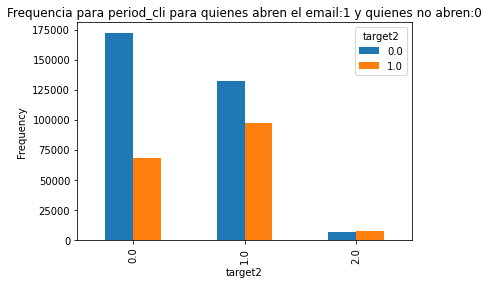

In [122]:
# periodo_cli

%matplotlib inline
pd.crosstab(data.periodo_cli, data.target2).plot(kind='bar')
plt.title('Frequencia para period_cli para quienes abren el email:1 y quienes no abren:0')
plt.xlabel('target2')
plt.ylabel('Frequency ')



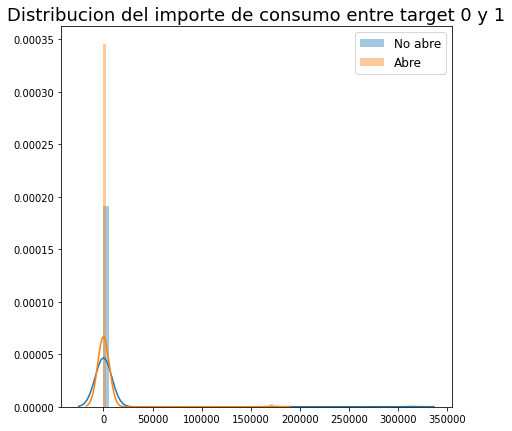

In [123]:
# importe_consumos


pivot = pd.pivot_table(data=data,
               index=['importe_consumos'],
                columns=['target2'],
               aggfunc=['size']
              )



fig = plt.figure(figsize = (7,7))

sns.distplot(pivot[('size', 0)], bins= 60, label = 'No abre')
sns.distplot(pivot[('size', 1)], bins= 60, label = 'Abre')

plt.title('Distribucion del importe de consumo entre target 0 y 1', fontsize=18)
plt.xlabel('', fontsize=16)
plt.ylabel('', fontsize=16)
plt.legend(prop={'size': 12})

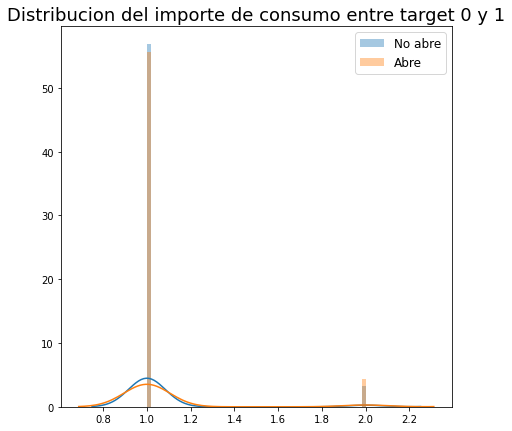

In [124]:
# excluimos las instancias de importe_consumo = 0 

pivot1 = pivot[pivot.index != 0]
pivot1


fig = plt.figure(figsize = (7,7))

sns.distplot(pivot1[('size', 0)], bins= 60, label = 'No abre')
sns.distplot(pivot1[('size', 1)], bins= 60, label = 'Abre')

plt.title('Distribucion del importe de consumo entre target 0 y 1', fontsize=18)
plt.xlabel('', fontsize=16)
plt.ylabel('', fontsize=16)
plt.legend(prop={'size': 12})

### Ingenieria de variables 

In [125]:
# Seleccionamos las columnas de tipo categoricas

data_cols_cat = data.select_dtypes(exclude=np.number) 

In [126]:
# data_cols_cat['FechaSaldos'].sort_values(ascending= True).head(5)

data_cols_cat['FechaVinculacion'].sort_values(ascending= True).head(5)

81592    1990-01-01
469927   1990-01-01
338536   1990-01-01
229128   1990-01-01
462236   1990-01-01
Name: FechaVinculacion, dtype: datetime64[ns]

#### Nueva variable : Antiguedad

In [127]:
# Calculamos los AÑOS desde la vinculacion a la empresa hasta la actualidad

data['antiguedad']=(data.FechaVinculacion.dt.year - datetime(2020,2,10).year)*-1

In [128]:
data.drop(columns='FechaVinculacion',inplace=True)

Text(0.5, 1.0, 'Distribucion de antiguedad por grupo')

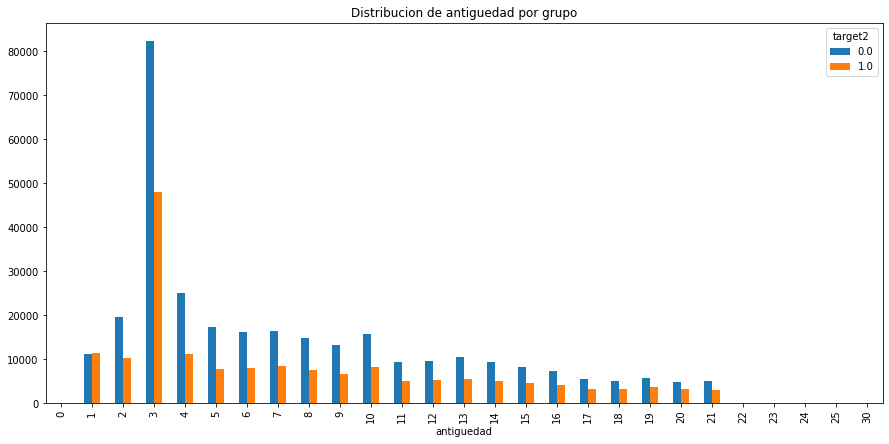

In [129]:

pd.crosstab(data.antiguedad, data.target2).plot(kind='bar', figsize = (15,7))
plt.title('Distribucion de antiguedad por grupo')

#### Nueva variable : 'Dias desde ultimo movimiento'

In [130]:
data_cols_cat['FechaUltMovCA'].sort_values(ascending= True).head(5)

208739   2004-04-19
442443   2004-04-19
282378   2004-06-30
444424   2005-02-24
210719   2005-02-24
Name: FechaUltMovCA, dtype: datetime64[ns]

Text(0.5, 1.0, 'Dias desde ùltimo movimiento')

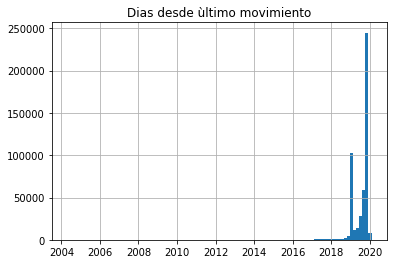

In [131]:
data_cols_cat['FechaUltMovCA'].hist(bins=100)
plt.title('Dias desde ùltimo movimiento')

In [132]:
# Diferencia entre la fecha de ultimo movimiento y la fecha actual

data['DiasDesdeMov']=((data.FechaUltMovCA.dt.date - datetime(2020,2,10).date())*-1).dt.days 


In [133]:
data = data.drop(['FechaUltMovCA'],axis=1)

In [134]:
data['DiasDesdeMov'].value_counts(normalize = True)


67     0.2577
68     0.0782
360    0.0669
69     0.0460
70     0.0443
        ...  
2896   0.0000
1715   0.0000
2078   0.0000
2132   0.0000
3070   0.0000
Name: DiasDesdeMov, Length: 971, dtype: float64

In [135]:
# Transformamos los outliers de esta nueva variable

cambiar(data, 'DiasDesdeMov')

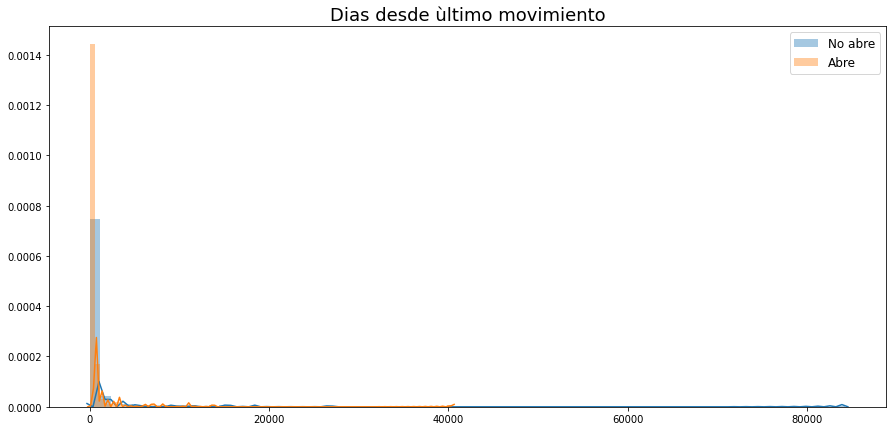

In [136]:
pivote = pd.pivot_table(data=data,
               index=['DiasDesdeMov'],
                columns=['target2'],
               aggfunc=['size']
              )



fig = plt.figure(figsize = (15,7))

sns.distplot(pivote[('size', 0)], bins= 70, label = 'No abre')
sns.distplot(pivote[('size', 1)], bins= 70, label = 'Abre')

plt.title('Dias desde ùltimo movimiento', fontsize=18)
plt.xlabel('', fontsize=16)
plt.ylabel('', fontsize=16)
plt.legend(prop={'size': 12})

In [137]:
#Eliminamos la columna FechaSaldos porque es irrelevante para el analisis 

data['FechaSaldos'].sort_values(ascending=False)
data = data.drop(['FechaSaldos'],axis=1)

### Transformacion de variables categoricas 

In [138]:
# Transformamos la variable sexo en dos variables dummy para posterior incorporacion al modelo de regresion.

data = pd.concat([data,pd.get_dummies(data.Sexo),pd.get_dummies(data.CategoriaProducto)],axis=1)

In [139]:
data = data.drop(['CategoriaProducto','Sexo'],axis=1)

In [140]:
# Tranformamos la variable de categoria de producto tambin en dummies

data['CategoriaProducto_10'] = data[10]
data['CategoriaProducto_12'] = data[12]
data['CategoriaProducto_14'] = data[14]
data['CategoriaProducto_19'] = data[19]
data['CategoriaProducto_28'] = data[28]
data['CategoriaProducto_OTRAS'] = data['OTRAS']

In [141]:
data['Sexo_M'] = data['M']

In [142]:
data['Sexo_F'] = data['F']

In [143]:
data = data.drop([10,12,14,19,28,'OTRAS','M','F'],axis=1)

In [144]:
# Creamos nuevas variables calculando la media de aquellas que tienen una division temporal

for col in data.columns:
    if col+'_ant_1' in data.columns:
        print("Calculating %s" % col)
        data[col+'_mean']=data[[col,col+'_ant_1',col+'_ant_2']].mean(axis=1)

Calculating cant_PF
Calculating cant_TC
Calculating cant_PP
Calculating importe_consumos
Calculating SaldoPromedioCAPesos
Calculating SaldoPromedioCADolares
Calculating SaldoPromedioCCAcreedor
Calculating TotalConsumoTD


### Interaccion entre variables 

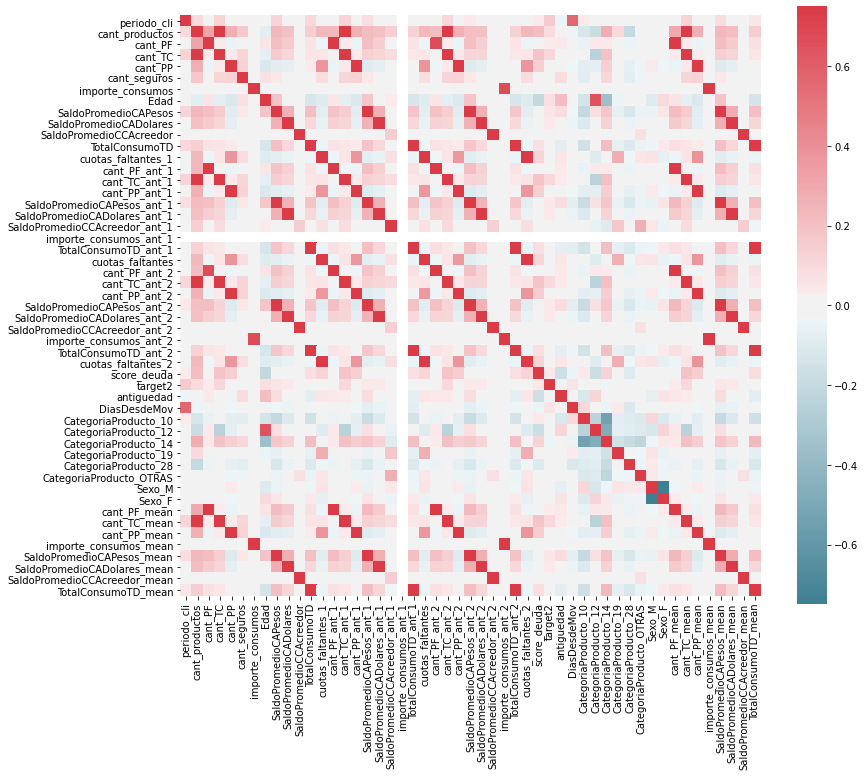

In [145]:

# Estudiamos la interaccion entre las variables 
# Definimos el min y max de correlacion a 75 %

f, ax = plt.subplots(figsize=(13, 11))
corr = data.corr()


sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
               square=True, ax=ax, annot=False, vmin=-0.75, vmax=0.75,)


# Preparacion de los datos para modelar la regresion logistica

In [146]:
### Selecionamos las variables que por su interaccion con el target vamos a probar en el modelo de reg logistica

variables = ['periodo_cli', 'Edad', 'cant_productos', 'cant_PF', 'cant_TC', 'cant_PP','SaldoPromedioCAPesos','SaldoPromedioCADolares','SaldoPromedioCAPesos_ant_2','SaldoPromedioCADolares_ant_2','score_deuda','target2', 'antiguedad', 'DiasDesdeMov','CategoriaProducto_10', 'CategoriaProducto_12','CategoriaProducto_14','CategoriaProducto_19','CategoriaProducto_28','CategoriaProducto_OTRAS', 'Sexo_M', 'Sexo_F','target2']

In [147]:
data = data.drop(columns=[col for col in data if col not in variables])
data

,periodo_cli,cant_productos,cant_PF,cant_TC,cant_PP,Edad,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCAPesos_ant_2,SaldoPromedioCADolares_ant_2,score_deuda,target2,antiguedad,DiasDesdeMov,CategoriaProducto_10,CategoriaProducto_12,CategoriaProducto_14,CategoriaProducto_19,CategoriaProducto_28,CategoriaProducto_OTRAS,Sexo_M,Sexo_F
0,0.0000,2.0000,0.0000,0.0000,0.0000,68.0000,6784.5000,0.0000,9440.5600,0.0000,1.0000,0.0000,3,70.0000,0,1,0,0,0,0,1,0
1,0.0000,1.0000,0.0000,0.0000,0.0000,67.0000,9231.1000,0.0000,5029.5900,0.0000,1.0000,0.0000,5,68.0000,0,1,0,0,0,0,0,1
2,0.0000,1.0000,0.0000,0.0000,0.0000,68.0000,47496.6100,0.0000,50156.3200,0.0000,0.0000,0.0000,3,67.0000,0,1,0,0,0,0,0,1
3,0.0000,6.0000,0.0000,3.0000,0.0000,68.0000,24806.5900,0.0000,26082.8500,0.0000,1.0000,0.0000,3,67.0000,0,1,0,0,0,0,0,1
4,0.0000,6.0000,1.0000,2.0000,0.0000,67.0000,75824.7800,470.0400,103080.4000,470.0400,0.0000,1.0000,3,67.0000,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494804,2.0000,1.0000,0.0000,0.0000,0.0000,46.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4,4.0000,0,0,0,0,0,1,0,1
494845,2.0000,1.0000,0.0000,0.0000,0.0000,60.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,2,4.0000,0,0,0,0,0,1,0,1
494872,2.0000,1.0000,0.0000,0.0000,0.0000,49.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,5,4.0000,0,0,0,0,0,1,0,1
494873,2.0000,1.0000,0.0000,0.0000,0.0000,37.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,4,140.0000,0,0,0,0,0,1,0,1


# Escalado de variables 

In [148]:
### Primero dividimos el data set en X (matriz de variables imput) e y (target)

y = data['target2']
y

0        0.0000
1        0.0000
2        0.0000
3        0.0000
4        1.0000
          ...  
494804   0.0000
494845   1.0000
494872   1.0000
494873   0.0000
494881   1.0000
Name: target2, Length: 484112, dtype: float64

In [149]:
X = data
X = X.drop(['target2'],axis=1)
X

,periodo_cli,cant_productos,cant_PF,cant_TC,cant_PP,Edad,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCAPesos_ant_2,SaldoPromedioCADolares_ant_2,score_deuda,antiguedad,DiasDesdeMov,CategoriaProducto_10,CategoriaProducto_12,CategoriaProducto_14,CategoriaProducto_19,CategoriaProducto_28,CategoriaProducto_OTRAS,Sexo_M,Sexo_F
0,0.0000,2.0000,0.0000,0.0000,0.0000,68.0000,6784.5000,0.0000,9440.5600,0.0000,1.0000,3,70.0000,0,1,0,0,0,0,1,0
1,0.0000,1.0000,0.0000,0.0000,0.0000,67.0000,9231.1000,0.0000,5029.5900,0.0000,1.0000,5,68.0000,0,1,0,0,0,0,0,1
2,0.0000,1.0000,0.0000,0.0000,0.0000,68.0000,47496.6100,0.0000,50156.3200,0.0000,0.0000,3,67.0000,0,1,0,0,0,0,0,1
3,0.0000,6.0000,0.0000,3.0000,0.0000,68.0000,24806.5900,0.0000,26082.8500,0.0000,1.0000,3,67.0000,0,1,0,0,0,0,0,1
4,0.0000,6.0000,1.0000,2.0000,0.0000,67.0000,75824.7800,470.0400,103080.4000,470.0400,0.0000,3,67.0000,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494804,2.0000,1.0000,0.0000,0.0000,0.0000,46.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4,4.0000,0,0,0,0,0,1,0,1
494845,2.0000,1.0000,0.0000,0.0000,0.0000,60.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,4.0000,0,0,0,0,0,1,0,1
494872,2.0000,1.0000,0.0000,0.0000,0.0000,49.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5,4.0000,0,0,0,0,0,1,0,1
494873,2.0000,1.0000,0.0000,0.0000,0.0000,37.0000,0.0000,0.0000,0.0000,0.0000,1.0000,4,140.0000,0,0,0,0,0,1,0,1


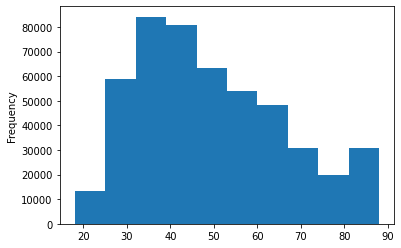

In [150]:
X['Edad'].plot.hist()

In [151]:
from sklearn.preprocessing import StandardScaler

In [152]:
X_scaled = StandardScaler().fit_transform(X.values)

In [153]:
X_scaled

array([[-0.9613117 , -0.84530883, -0.28623624, ..., -0.208151  ,
         1.14344211, -1.14344211],
       [-0.9613117 , -1.44721438, -0.28623624, ..., -0.208151  ,
        -0.87455236,  0.87455236],
       [-0.9613117 , -1.44721438, -0.28623624, ..., -0.208151  ,
        -0.87455236,  0.87455236],
       ...,
       [ 2.65256607, -1.44721438, -0.28623624, ...,  4.80420462,
        -0.87455236,  0.87455236],
       [ 2.65256607, -1.44721438, -0.28623624, ...,  4.80420462,
        -0.87455236,  0.87455236],
       [ 2.65256607, -1.44721438, -0.28623624, ...,  4.80420462,
        -0.87455236,  0.87455236]])

In [154]:
X_scaled_df = pd.DataFrame(X_scaled, index=data.index, columns=X.columns)

In [155]:
X_scaled_df.head()

,periodo_cli,cant_productos,cant_PF,cant_TC,cant_PP,Edad,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCAPesos_ant_2,SaldoPromedioCADolares_ant_2,score_deuda,antiguedad,DiasDesdeMov,CategoriaProducto_10,CategoriaProducto_12,CategoriaProducto_14,CategoriaProducto_19,CategoriaProducto_28,CategoriaProducto_OTRAS,Sexo_M,Sexo_F
0,-0.9613,-0.8453,-0.2862,-1.2748,-0.4632,1.1213,-0.5228,-0.2865,-0.4100,-0.2841,0.3398,-0.8119,-0.7840,-0.5167,2.1726,-1.0433,-0.1440,-0.1802,-0.2082,1.1434,-1.1434
1,-0.9613,-1.4472,-0.2862,-1.2748,-0.4632,1.0620,-0.4725,-0.2865,-0.5174,-0.2841,0.3398,-0.4413,-0.7992,-0.5167,2.1726,-1.0433,-0.1440,-0.1802,-0.2082,-0.8746,0.8746
2,-0.9613,-1.4472,-0.2862,-1.2748,-0.4632,1.1213,0.3145,-0.2865,0.5816,-0.2841,-2.9427,-0.8119,-0.8067,-0.5167,2.1726,-1.0433,-0.1440,-0.1802,-0.2082,-0.8746,0.8746
3,-0.9613,1.5623,-0.2862,1.6762,-0.4632,1.1213,-0.1522,-0.2865,-0.0047,-0.2841,0.3398,-0.8119,-0.8067,-0.5167,2.1726,-1.0433,-0.1440,-0.1802,-0.2082,-0.8746,0.8746
4,-0.9613,1.5623,2.2996,0.6925,-0.4632,1.0620,0.8970,0.1758,1.8705,0.1050,-2.9427,-0.8119,-0.8067,-0.5167,-0.4603,0.9585,-0.1440,-0.1802,-0.2082,-0.8746,0.8746


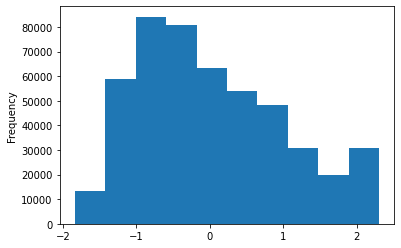

In [156]:
X_scaled_df['Edad'].plot.hist()

## Dividimos dataset para entrenar el modelo

In [157]:
from sklearn.model_selection import train_test_split

In [158]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled_df,y)

In [159]:
X_train

,periodo_cli,cant_productos,cant_PF,cant_TC,cant_PP,Edad,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCAPesos_ant_2,SaldoPromedioCADolares_ant_2,score_deuda,antiguedad,DiasDesdeMov,CategoriaProducto_10,CategoriaProducto_12,CategoriaProducto_14,CategoriaProducto_19,CategoriaProducto_28,CategoriaProducto_OTRAS,Sexo_M,Sexo_F
273836,0.8456,0.3585,-0.2862,-1.2748,-0.4632,0.5883,3.8255,-0.2865,0.6687,2.9057,0.3398,2.1525,0.8827,1.9355,-0.4603,-1.0433,-0.1440,-0.1802,-0.2082,1.1434,-1.1434
172516,-0.9613,-0.8453,-0.2862,-0.2912,-0.4632,-1.0698,-0.6623,-0.2865,-0.6399,-0.2841,0.3398,-0.0708,0.0342,1.9355,-0.4603,-1.0433,-0.1440,-0.1802,-0.2082,-0.8746,0.8746
227080,-0.9613,-0.2434,-0.2862,-0.2912,-0.4632,1.8319,0.3129,0.5712,0.1640,0.2888,0.3398,-0.8119,-0.8067,-0.5167,2.1726,-1.0433,-0.1440,-0.1802,-0.2082,-0.8746,0.8746
124230,-0.9613,2.1642,-0.2862,0.6925,2.1587,-0.5960,-0.2308,-0.2865,-0.4257,-0.2839,0.3398,0.2998,-0.7916,-0.5167,-0.4603,0.9585,-0.1440,-0.1802,-0.2082,1.1434,-1.1434
125625,-0.9613,-1.4472,-0.2862,-1.2748,-0.4632,-0.5960,0.5364,-0.2865,-0.5512,-0.2841,0.3398,1.0409,-0.8067,-0.5167,-0.4603,0.9585,-0.1440,-0.1802,-0.2082,-0.8746,0.8746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212973,-0.9613,0.3585,-0.2862,-0.2912,2.1587,1.4173,0.7972,5.0965,0.8971,5.0562,0.3398,-0.6266,-0.8067,-0.5167,2.1726,-1.0433,-0.1440,-0.1802,-0.2082,1.1434,-1.1434
103104,-0.9613,-0.8453,-0.2862,-0.2912,-0.4632,-0.4184,-0.6623,-0.2865,-0.6399,-0.2841,0.3398,-0.6266,2.2918,1.9355,-0.4603,-1.0433,-0.1440,-0.1802,-0.2082,1.1434,-1.1434
473974,0.8456,-0.2434,-0.2862,-0.2912,-0.4632,0.9436,-0.5023,-0.2865,0.2989,-0.2841,0.3398,-0.0708,1.0039,1.9355,-0.4603,-1.0433,-0.1440,-0.1802,-0.2082,1.1434,-1.1434
227104,-0.9613,-1.4472,-0.2862,-1.2748,-0.4632,2.2464,0.8090,-0.2865,-0.2661,-0.2841,-2.9427,2.5231,-0.7916,-0.5167,2.1726,-1.0433,-0.1440,-0.1802,-0.2082,-0.8746,0.8746


## Corregimos el desbalance de clase en la columna target2

In [160]:
from sklearn.utils import resample

In [161]:
y_train.value_counts(normalize = True)

0.0000   0.6431
1.0000   0.3569
Name: target2, dtype: float64

In [162]:

df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)

In [163]:
negative = df[df['target2']==0]
positive = df[df['target2']==1]# upsample minority
pos_upsampled = resample(positive,
     replace=True, # sample with replacement
     n_samples=len(negative), # match number in majority class
     random_state=27) # reproducible results# combine majority and upsampled minority
upsampled = pd.concat([negative, pos_upsampled])# check new class counts
upsampled['target2'].value_counts()

1.0000    233493
0.0000    233493
Name: target2, dtype: int64

In [164]:
from sklearn.utils import shuffle
upsampled = shuffle(upsampled)

In [165]:
X_train = upsampled 
X_train = X_train.drop(['target2'],axis=1)

y_train = upsampled['target2']

In [166]:
X_train 

,periodo_cli,cant_productos,cant_PF,cant_TC,cant_PP,Edad,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCAPesos_ant_2,SaldoPromedioCADolares_ant_2,score_deuda,antiguedad,DiasDesdeMov,CategoriaProducto_10,CategoriaProducto_12,CategoriaProducto_14,CategoriaProducto_19,CategoriaProducto_28,CategoriaProducto_OTRAS,Sexo_M,Sexo_F
64236,-0.9613,0.3585,-0.2862,0.6925,-0.4632,0.1146,-0.4531,-0.2865,-0.5974,-0.2841,0.3398,0.2998,-0.8067,1.9355,-0.4603,-1.0433,-0.1440,-0.1802,-0.2082,1.1434,-1.1434
185314,-0.9613,-0.8453,-0.2862,-0.2912,-0.4632,-1.2474,-0.4854,-0.2865,-0.3530,-0.2841,-2.9427,-0.6266,-0.8067,1.9355,-0.4603,-1.0433,-0.1440,-0.1802,-0.2082,1.1434,-1.1434
52205,-0.9613,-0.2434,-0.2862,-0.2912,-0.4632,0.2330,-0.0271,0.1593,0.0925,-0.2841,0.3398,-0.0708,-0.8067,-0.5167,-0.4603,0.9585,-0.1440,-0.1802,-0.2082,1.1434,-1.1434
44608,-0.9613,2.7661,2.2996,2.6599,-0.4632,0.3514,1.5630,2.4971,2.3111,5.0562,0.3398,-0.8119,-0.7992,-0.5167,-0.4603,0.9585,-0.1440,-0.1802,-0.2082,1.1434,-1.1434
191267,-0.9613,-0.2434,-0.2862,-0.2912,2.1587,-1.3066,-0.3812,-0.2865,-0.2341,-0.2841,0.3398,-0.6266,-0.7916,-0.5167,-0.4603,0.9585,-0.1440,-0.1802,-0.2082,1.1434,-1.1434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167815,-0.9613,-0.2434,-0.2862,-0.2912,-0.4632,-1.0106,-0.2091,-0.0651,-0.2627,-0.0487,0.3398,-0.2560,-0.8067,-0.5167,-0.4603,0.9585,-0.1440,-0.1802,-0.2082,-0.8746,0.8746
374914,0.8456,-0.2434,-0.2862,-0.2912,-0.4632,-0.7145,0.1340,-0.2853,-0.3939,-0.2831,-2.9427,-0.6266,1.1100,-0.5167,-0.4603,0.9585,-0.1440,-0.1802,-0.2082,-0.8746,0.8746
474479,0.8456,-0.8453,-0.2862,-0.2912,-0.4632,1.4766,-0.5102,-0.2865,0.3111,-0.2841,0.3398,1.0409,1.1251,-0.5167,2.1726,-1.0433,-0.1440,-0.1802,-0.2082,-0.8746,0.8746
55960,-0.9613,-1.4472,-0.2862,-1.2748,-0.4632,0.2330,0.3231,-0.2865,0.8164,-0.2841,0.3398,-0.8119,-0.7916,-0.5167,-0.4603,0.9585,-0.1440,-0.1802,-0.2082,-0.8746,0.8746


In [167]:
y_train

64236    0.0000
185314   0.0000
52205    1.0000
44608    0.0000
191267   0.0000
          ...  
167815   0.0000
374914   1.0000
474479   1.0000
55960    0.0000
488466   1.0000
Name: target2, Length: 466986, dtype: float64

# Resgression logistica 

In [168]:
from sklearn.linear_model import LogisticRegression

In [169]:
logreg = LogisticRegression(penalty='l2',solver='lbfgs',C=0.1,max_iter=10000)

In [170]:
logreg.fit(X_train,y_train)

LogisticRegression(C=0.1, max_iter=10000)

In [171]:
logreg.score(X_train, y_train)

0.5930863023730905

In [172]:
y_pred_train = logreg.predict(X_train)

In [173]:
y_preds_test = logreg.predict_proba(X_test)

In [174]:
print('Accuracy en train: ',  logreg.score(X_train, y_train))

Accuracy en train:  0.5930863023730905


In [175]:
print('Accuracy en test: ',  logreg.score(X_test, y_test))

Accuracy en test:  0.5957547013914135


In [176]:
y_preds = logreg.predict(X_test)

y_preds


array([1., 0., 1., ..., 1., 0., 0.])

In [177]:

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_preds)
print(confusion_matrix)

[[46920 31070]
 [17855 25183]]


In [178]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.72      0.60      0.66     77990
         1.0       0.45      0.59      0.51     43038

    accuracy                           0.60    121028
   macro avg       0.59      0.59      0.58    121028
weighted avg       0.63      0.60      0.60    121028



In [179]:

## Construimos curva roc para evaluar desempeño del modelo 

import sklearn.metrics as metrics

In [180]:
preds = y_preds_test[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

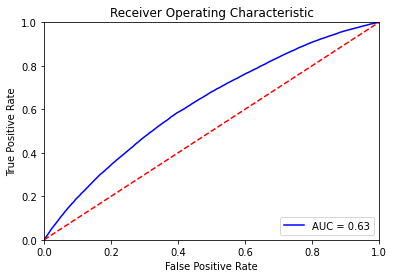

In [181]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Regression logistica con RFE (Recursive Feature Elimination)

In [182]:
from sklearn.feature_selection import RFE

#  (RFE) is a feature selection method that fits a model and 
# removes the weakest features

In [183]:
logreg = LogisticRegression(penalty='l2',solver='lbfgs',C=0.1,max_iter=10000)

In [184]:
rfe = RFE(logreg, 25)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/home/juanfi/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=25 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [185]:
rfe

RFE(estimator=LogisticRegression(C=0.1, max_iter=10000),
    n_features_to_select=25)

In [186]:
y_preds1 = rfe.predict(X_test)

y_preds1


array([1., 0., 1., ..., 1., 0., 0.])

In [187]:
print('Accuracy en train: ',  rfe.score(X_train, y_train))

Accuracy en train:  0.5930863023730905


In [188]:
print('Accuracy en test: ',  rfe.score(X_test, y_test))

Accuracy en test:  0.5957547013914135


In [189]:

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_preds1)
print(confusion_matrix)

[[46920 31070]
 [17855 25183]]


In [190]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds1))

              precision    recall  f1-score   support

         0.0       0.72      0.60      0.66     77990
         1.0       0.45      0.59      0.51     43038

    accuracy                           0.60    121028
   macro avg       0.59      0.59      0.58    121028
weighted avg       0.63      0.60      0.60    121028

